In [0]:
 from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip "/content/drive/My Drive/cs4990-fall2019-assignment-3.zip" -d "/content/drive/My Drive"
#!unzip "/content/drive/My Drive/img_align_celeba.zip" -d "/content"

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Lambda, Conv2D, concatenate, MaxPool2D,Conv2DTranspose, Flatten, Dropout, MaxPooling2D, Reshape, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19


from tensorflow.keras.applications.vgg19 import preprocess_input


import os
import sys
import random
import warnings
import datetime
import numpy as np
import pandas as pd

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import matplotlib.pyplot as plt

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

#consts
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 3
batchsize = 150
PATH = "/content/drive/My Drive/"
TRAIN_IMG_PATH = "/content/drive/My Drive/training_images/training_images/"
TRAIN_MASK_PATH = "/content/drive/My Drive/training_masks/training_masks/"
TEST_PATH = "/content/drive/My Drive/testing_images/testing_images/"
VALIDATION_IMAGES = "/content/drive/My Drive/validation_images/validation_images/"
VALIDATION_MASKS = "/content/drive/My Drive/validation_masks/validation_masks/"
print(tf.__version__)

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

2.0.0


In [0]:

# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [0]:
#sorting list of images names
train_ids = os.listdir(TRAIN_IMG_PATH )
mask_ids = os.listdir(TRAIN_MASK_PATH)
#test_ids = os.listdir(TEST_PATH)
test_ids = os.listdir('/content/img_align_celeba')
train_ids.sort()
mask_ids.sort()
#test_ids.sort(key = lambda a: int(a.split("_")[2].split('.')[0]))
print(train_ids)
print(mask_ids)
print(test_ids)

['train_img_1.jpg', 'train_img_10.jpg', 'train_img_100.jpg', 'train_img_1000.jpg', 'train_img_1001.jpg', 'train_img_1002.jpg', 'train_img_1003.jpg', 'train_img_1004.jpg', 'train_img_1005.jpg', 'train_img_1006.jpg', 'train_img_1007.jpg', 'train_img_1008.jpg', 'train_img_1009.jpg', 'train_img_101.jpg', 'train_img_1010.jpg', 'train_img_1011.jpg', 'train_img_1012.jpg', 'train_img_1013.jpg', 'train_img_1014.jpg', 'train_img_1015.jpg', 'train_img_1016.jpg', 'train_img_1017.jpg', 'train_img_1018.jpg', 'train_img_1019.jpg', 'train_img_102.jpg', 'train_img_1020.jpg', 'train_img_1021.jpg', 'train_img_1022.jpg', 'train_img_1023.jpg', 'train_img_1024.jpg', 'train_img_1025.jpg', 'train_img_1026.jpg', 'train_img_1027.jpg', 'train_img_1028.jpg', 'train_img_1029.jpg', 'train_img_103.jpg', 'train_img_1030.jpg', 'train_img_1031.jpg', 'train_img_1032.jpg', 'train_img_1033.jpg', 'train_img_1034.jpg', 'train_img_1035.jpg', 'train_img_1036.jpg', 'train_img_1037.jpg', 'train_img_1038.jpg', 'train_img_1039.jp

In [0]:
#another attempt to resize images and masks (working version)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_IMG_PATH + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
for n,mask_file in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(TRAIN_MASK_PATH + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask
print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 1500/1500 [10:45<00:00,  1.83it/s]

Done!


Getting and resizing test images ... 


<function matplotlib.pyplot.show>

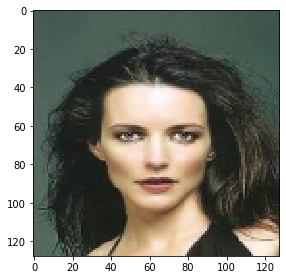

In [0]:
# Get and resize test image for single test
X_test = np.zeros((len(test_ids), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')

img = imread('/content/img_align_celeba/000035.jpg')[:,:,:IMG_CHANNELS]
sizes_test.append([img.shape[0], img.shape[1]])
img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
X_test[0] = img
imshow(X_test[0])
plt.show

In [0]:
# Get and resize test images from previous test images
X_test = np.zeros((len(test_ids), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH + id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 927/927 [06:32<00:00,  2.04it/s]


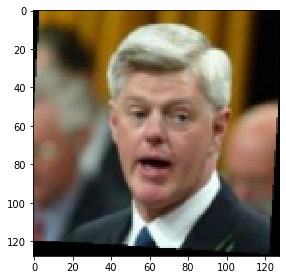

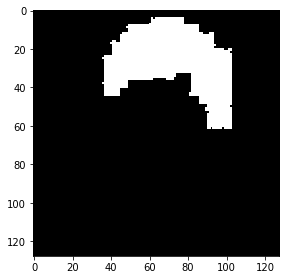

In [0]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Build U-Net model with vgg on top
#inputs = Input((4, 4, 1024))
inputs = Input((IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

enc = VGG19(weights = "imagenet", include_top=False, input_shape = (128 , 128, 3))(s)
#top = enc.output
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (enc)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["Accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 256)         1179904   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 256)         590080    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         1312

In [0]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
tb = TensorBoard(histogram_freq=1)
checkpointer = ModelCheckpoint('/content/drive/My Drive/improved_modelf.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

In [0]:
tensorboard --logdir logs/fit

2178/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

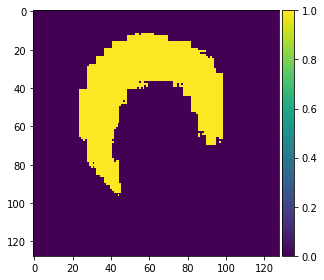

In [0]:
#for single image testing
model = load_model('/content/drive/My Drive/improved_modelf.h5')
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
imshow(np.squeeze(preds_test_t[0]))

In [0]:
# Predict on train, val and test
model = load_model('/content/drive/My Drive/improved_modelf.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
#print(preds_test_upsampled.shape())

1350/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

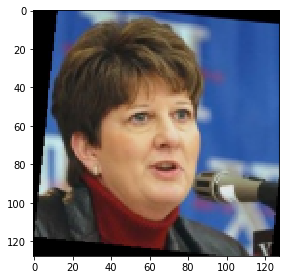

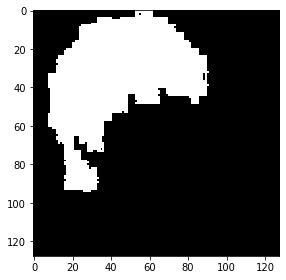

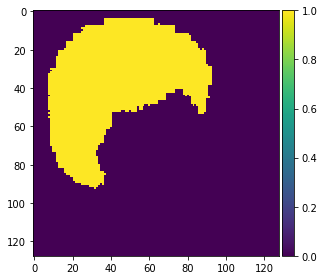

In [0]:
# Perform a sanity check on some random training samples
ix = 4#random.randint(0, len(preds_train_t))
imshow(X_train[ix]/255)
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

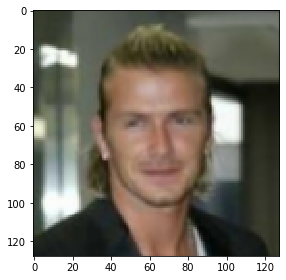

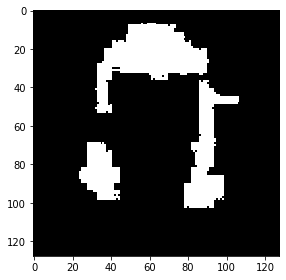

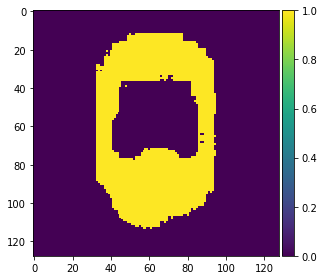

In [0]:
# This was to check if transfer learning truly improved the model, it did
ix = 3#random.randint(0, len(preds_train_t))
imshow(X_train[ix]/255)
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

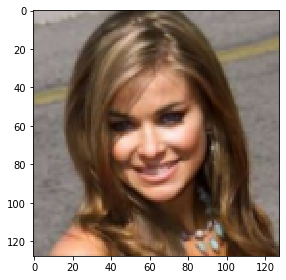

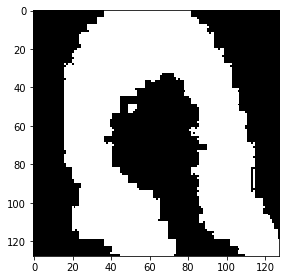

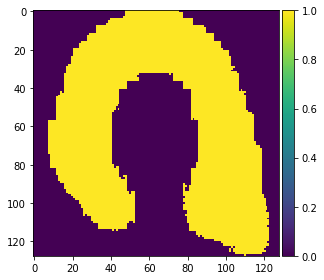

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [0]:
!mkdir test_masks

In [0]:
from skimage import img_as_ubyte
from skimage.io import imsave

def saving_masks(preds):
  for i in range(len(preds)):
    file = test_ids[i].replace('img','mask')
    imsave(os.path.join('test_masks/',file), img_as_ubyte(preds[i]))

In [0]:
saving_masks(preds_test_upsampled)

In [0]:
masks = [f for f in os.listdir("test_masks/") if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))


In [0]:
encodings = []
for file in masks:
    mask = imread(os.path.join("test_masks/", file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))

In [0]:
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('test_masks/', 'test_seg1.csv'), index=False)

Old Model

In [0]:
# Build U-Net model
inputs = Input((IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["Accuracy"])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 128, 128, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 128, 128, 16) 448         lambda_6[0][0]                   
__________________________________________________________________________________________________
dropout_45 (Dropout)            (None, 128, 128, 16) 0           conv2d_96[0][0]                  
____________________________________________________________________________________________

Old method(?)

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('finalattemptfinalx.csv', index=False)

In [0]:
# image preprocessing using generators **example *attempt
#perhaps if I could sort my directory which was one of the problems 
#I later found the generators could work
#no time so though so I do not know

#data_gen_args = dict(featurewise_center=True,
#                     featurewise_std_normalization=True,
#                     rotation_range=90,
#                     width_shift_range=0.1,
#                     height_shift_range=0.1,
#                     zoom_range=0.2)
data_gen_args = dict(rescale=1./255)
# we create two instances with the same arguments
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
#at some point I tried using no augmentations and just the generator
#image_datagen = ImageDataGenerator()
#mask_datagen = ImageDataGenerator()
# Provide the same seed and keyword arguments to the fit and flow methods

#Following code went through many changes the state it is in now
#is simply the last state it was in when I abandoned the 
#generator method
image_generator = image_datagen.flow_from_directory(
    TRAIN_IMG_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='input',
    batch_size=100,
    seed=2)

mask_generator = mask_datagen.flow_from_directory(
    TRAIN_MASK_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='input',
    batch_size=100,
    color_mode='grayscale',
    seed=2)

vimage_generator = image_datagen.flow_from_directory(
    VALIDATION_IMAGES,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='input',
    batch_size=100,
    seed=1)

vmask_generator = mask_datagen.flow_from_directory(
    VALIDATION_MASKS,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='input',
    batch_size=100,
    color_mode = 'grayscale',
    seed=1)
# combine generators into one which yields image and masks
#in some verision(s)(?) of tf zip is not considered a generator
#therefore the pair for pair code is a workaround
#note did not work or maybe it did and the sorting problem caused an error idk

#train_generator = (pair for pair in zip(image_generator, mask_generator))
#valid_generator = (pair for pair in zip(vimage_generator, vmask_generator))
#train_generator = zip(image_generator, mask_generator)
#valid_generator = zip(vimage_generator, vmask_generator)

#This is the second work around the zip problem
#which is I just made my own generator
#again may or may not have worked no idea
def new_generator(a,b): #a,b are image and mask generators
  while 'shiv'=='shiv':
    a1 = a.next()
    b1 = b.next()
    yield(a1[0], b1[0])

train_generator = new_generator(image_generator,mask_generator)
valid_generator = new_generator(vimage_generator,vimage_generator)


Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


In [0]:
# Fit model gen *attempt
#like above block this code went through a number of changes and this is simply
#the last state of the code before switch

#note would often result in one of two errors either empty training data
#or int not callable(after looking at the stack trace some derivative function would cause this and not my own code), it would alternate under most circumstances
#a third error would pop up however I forgot what it was since I new what caused it and often I would cause it

#second note I was able to get it down to a single consistent error through turning off shuffle
#however it would still be one of the two it would simply be stuck with one rather then alternate

#third note using multiprocessing would work (in some version of this code) however would 
#get stuck on first epoch I believe it may be because of the sorting problem unsure though
#making use of multiple workers did not however and would again result in one of two errors
#using both would be pointless and create copies of data but I tried 
#and if I remember correctly it would get stuck like when using multiprocessing rather then an error
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('unet-ml-a3.h5', verbose=1, save_best_only=True)
#cb = [earlystopper,checkpointer]
results = model.fit_generator(train_generator, steps_per_epoch=500, epochs=1,callbacks=[earlystopper,checkpointer], validation_data=valid_generator, validation_steps=1)

ValueError: ignored